In [ ]:
# Importing Libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [ ]:
# import dataset

df=pd.read_csv('/content/all_stocks_2017-01-01_to_2018-01-01.csv',parse_dates=['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2017-01-03,178.83,180.00,177.22,178.05,2510055,MMM
1,2017-01-04,178.03,178.90,177.61,178.32,1541985,MMM
2,2017-01-05,178.26,179.14,176.89,177.71,1447848,MMM
3,2017-01-06,177.29,178.60,175.80,178.23,1625049,MMM
4,2017-01-09,178.37,178.38,177.20,177.27,1622625,MMM


Data Cleaning

In [ ]:
df.isnull().sum()

Date       0
Open      24
High       9
Low       19
Close      0
Volume     0
Name       0
dtype: int64

In [ ]:
df.drop(['Open','Low','High','Volume'],axis=1,inplace=True)

In [ ]:
df.tail()

,Date,Close,Name
7776,2017-12-22,71.58,AABA
7777,2017-12-26,69.86,AABA
7778,2017-12-27,70.06,AABA
7779,2017-12-28,69.82,AABA
7780,2017-12-29,69.85,AABA


EDA

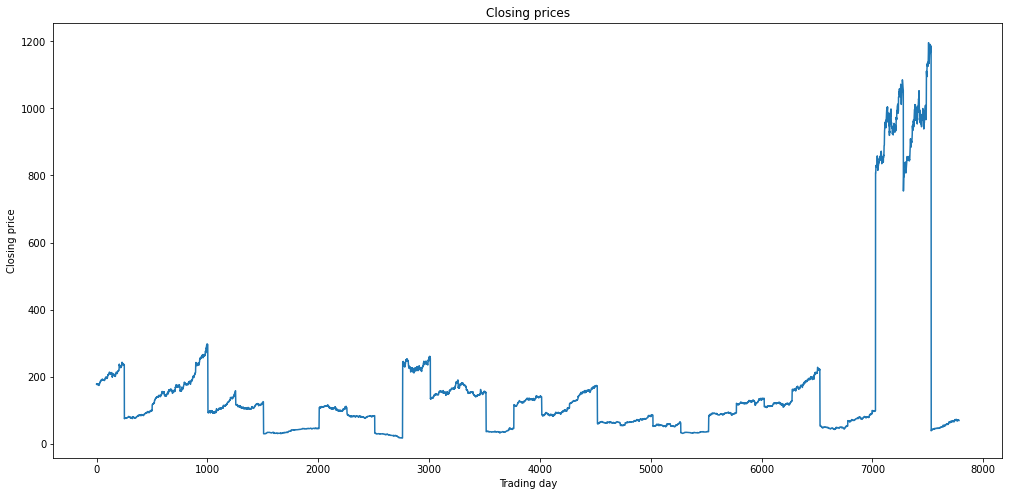

In [ ]:
plt.figure(figsize=(17,8))
plt.plot(df.Close)
plt.title('Closing prices')
plt.xlabel('Trading day')
plt.ylabel('Closing price')
plt.grid(False)
plt.show()

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.tail()

,index,Date,Close,Name
7776,7776,2017-12-22,71.58,AABA
7777,7777,2017-12-26,69.86,AABA
7778,7778,2017-12-27,70.06,AABA
7779,7779,2017-12-28,69.82,AABA
7780,7780,2017-12-29,69.85,AABA


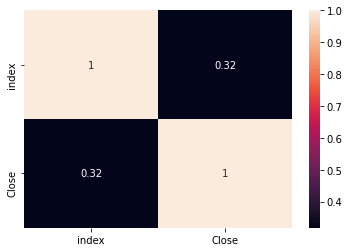

In [ ]:
import seaborn as sns
correlation=df.corr()
sns.heatmap(correlation,annot=True)

In [ ]:
Close=df['Close']
index=df['index']

In [ ]:
def plot_series(time,series,format='-',start=0,end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel('Time')
  plt.ylabel('value')
  plt.grid(True)
  plt.show()

In [ ]:
series=np.array(Close)
time=np.array(index)

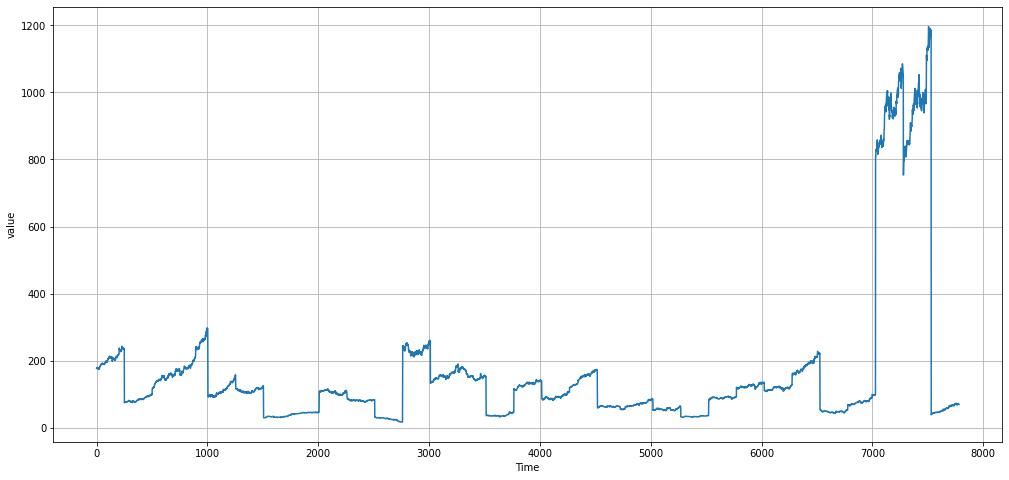

In [ ]:
plt.figure(figsize=(17,8))
plot_series(time,series)

Splitting Data into Training and Validation

In [ ]:
split_time=7000
time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_valid=time[split_time:]

window_size=30
batch_size=32
shuffle_buffer_size=1000

Creating Windowed dataset, so that data gets inputs and targets

In [ ]:
def windowed_dataset(series,window,batch_size,shuffle_buffer):
  series=tf.expand_dims(series,axis=-1)
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size+1,shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda w: w.batch(window_size+1))
  dataset=dataset.shuffle(shuffle_buffer)
  dataset=dataset.map(lambda w:(w[:-1],w[1:]))
  dataset=dataset.batch(batch_size).prefetch(1)
  return dataset

Forecasting data using Helper Function

In [ ]:
def model_forecast(model,series,window_size):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size,shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda w: w.batch(window_size))
  dataset=dataset.batch(32).prefetch(1)
  forecast=model.predict(dataset)
  return forecast

Import Some essential libaries to train our model

And our model is trained on LSTM, Bidirectional and some dense layers using tensorflow

Mainly, I'm training our model trained based on learning rate & super cool loss function called "Huber" with "mae" metrics.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,Conv1D,Dropout,Lambda

In [ ]:
tf.keras.backend.clear_session()
window_size=64
batch_size=128
train_set=windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

print(train_set)
print(x_train.shape)

model=Sequential()
model.add(LSTM(128,input_shape=[None,1],return_sequences=True))
model.add(LSTM(64,return_sequences=True))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Dense(32,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(1))

optimizer=tf.keras.optimizers.SGD(lr=1e-5,momentum=0.9)
model.compile(optimizer=optimizer,loss=tf.keras.losses.Huber(),metrics=['mae'])

history=model.fit(train_set,epochs=10)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(7000,)
Epoch 1/10
55/55 [==============================] - 39s 80ms/step - loss: 119.3306 - mae: 119.8306
Epoch 2/10
55/55 [==============================] - 5s 79ms/step - loss: 118.1878 - mae: 118.6878
Epoch 3/10
55/55 [==============================] - 5s 79ms/step - loss: 118.3101 - mae: 118.8101
Epoch 4/10
55/55 [==============================] - 5s 79ms/step - loss: 118.1436 - mae: 118.6436
Epoch 5/10
55/55 [==============================] - 5s 79ms/step - loss: 118.1408 - mae: 118.6408
Epoch 6/10
55/55 [==============================] - 5s 79ms/step - loss: 117.9446 - mae: 118.4446
Epoch 7/10
55/55 [==============================] - 5s 79ms/step - loss: 117.9996 - mae: 118.4996
Epoch 8/10
55/55 [==============================] - 5s 79ms/step - loss: 117.9308 - mae: 118.4308
Epoch 9/10
55/55 [==============================] - 5s 79ms/step - loss: 118.7254 - mae: 119.2254
Epoch 10/10
55/

LOL.....Don't get tensed with huge metrics we could figure it out by using Conv1D & lambda

Using Conv1D we could get some features to identify by our model, later using LSTM's the model get trained too good.

Let's hope for the best. let's SEE!!

In [ ]:
tf.keras.backend.clear_session()
window_size=64
batch_size=128
train_set=windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

print(train_set)
print(x_train.shape)

model=Sequential()
model.add(Conv1D(filters=60,kernel_size=5,padding="causal",strides=1,activation='relu',input_shape=[None,1]))
model.add(LSTM(128,return_sequences=True))
#model.add(Dropout(0.3))
model.add(LSTM(64,return_sequences=True))
#model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Dense(32,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(1))
model.add(Lambda(lambda x: x * 400))

optimizer=tf.keras.optimizers.SGD(lr=1e-5,momentum=0.9)
model.compile(optimizer=optimizer,loss=tf.keras.losses.Huber(),metrics=['mae'])

history=model.fit(train_set,epochs=10)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(7000,)
Epoch 1/10
55/55 [==============================] - 11s 83ms/step - loss: 64.9424 - mae: 65.4378
Epoch 2/10
55/55 [==============================] - 5s 81ms/step - loss: 15.8372 - mae: 16.3275
Epoch 3/10
55/55 [==============================] - 5s 82ms/step - loss: 11.4670 - mae: 11.9501
Epoch 4/10
55/55 [==============================] - 5s 82ms/step - loss: 9.2475 - mae: 9.7311
Epoch 5/10
55/55 [==============================] - 5s 82ms/step - loss: 12.2041 - mae: 12.6947
Epoch 6/10
55/55 [==============================] - 5s 82ms/step - loss: 9.6041 - mae: 10.0905
Epoch 7/10
55/55 [==============================] - 5s 82ms/step - loss: 8.3775 - mae: 8.8627
Epoch 8/10
55/55 [==============================] - 5s 81ms/step - loss: 9.1186 - mae: 9.6022
Epoch 9/10
55/55 [==============================] - 5s 82ms/step - loss: 5.5939 - mae: 6.0660
Epoch 10/10
55/55 [=======================

Hooray !! 

We made it....see the mae figure its too good than i expected

(1e-05, 0.0001, 0.0, 60.0)

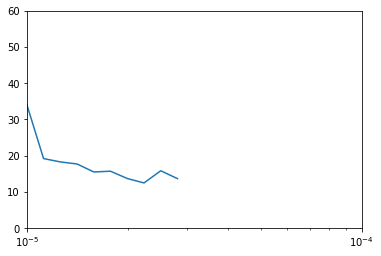

In [ ]:
# plotting the axis

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-4, 0, 60])

In [ ]:
# Let's Forecast with the helper function that we made earlier

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

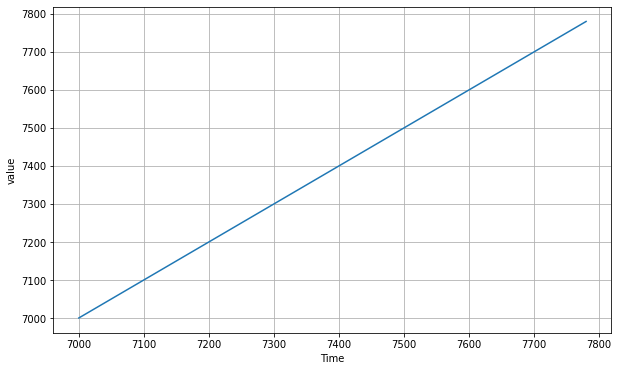

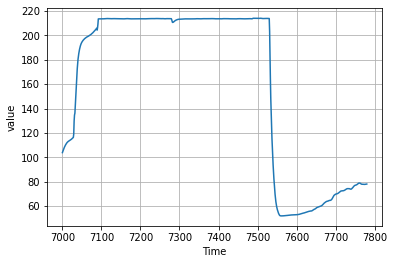

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Good!!

I got the forecasting output. And its working 

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

7229.0806

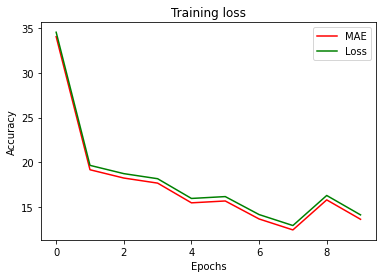

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']
mae =history.history['mae']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs,mae,'g')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE","Loss"])

The model is working great and the accuracy is too good.

Thanks. Happy Learning!!